# Skin cancer detection using the HAM dataset




In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import random 
import os
from PIL import Image 
import shutil
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
 

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Mounting to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Config path to kaggle.json

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

# Change current working directory

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/kaggle
#Check the present working directory using pwd command
#!pwd


/content/gdrive/My Drive/kaggle


# Downlaoding the Kaggle dataset

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [01:25<00:00, 71.4MB/s]
100% 5.20G/5.20G [01:25<00:00, 65.4MB/s]


# Unzipping and removing the zip files

In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

# Importing the data

In [ ]:
HAM_1 = '/content/gdrive/My Drive/kaggle/HAM10000_images_part_1'
HAM_2 = '/content/gdrive/My Drive/kaggle/HAM10000_images_part_2'

HAM_1_list = os.listdir(HAM_1)
HAM_2_list = os.listdir(HAM_2)

metadata = pd.read_csv('/content/gdrive/My Drive/kaggle/HAM10000_metadata.csv')

#metadata.isnull().sum()

# Organizing Data

In [ ]:
#Transfer files from HAM10000_images_part_2 to part_1 for ease of access and usage
for file in HAM_2_list:
  dir = os.path.join(HAM_2,file)
  dest = shutil.move(dir,HAM_1)

#Dictionary containing the labels for various types of skin cancer to make labelling easier later on
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#Dictionary containing images as key and image path as value to make labels easier later on
imageid_dict = {os.path.splitext(os.path.basename(x))[0]:x
                for x in glob.glob(os.path.join(HAM_1,'*.jpg'))}

metadata['dx'] = metadata['dx'].astype(str)
metadata['image_id'] = metadata['image_id'].astype(str)

#cleaning data to remove unknowns and nans
metadata.fillna(round(np.mean(metadata['age'])),inplace=True)
metadata.loc[(metadata['sex']=='unknown','sex')] = random.choice(['male','female'])
metadata.loc[(metadata['localization']=='unknown','localization')] = random.choice(['back','lower extremity','trunk','upper extremity','abdomen','face','chest','foot','neck','scalp','hand','ear','genital','acral'])
#metadata.head(980)

# Reading and Processing data

In [ ]:
metadata['path'] = metadata['image_id'].map(imageid_dict)
metadata['cell_type'] = metadata['dx'].map(lesion_type_dict)
metadata['image'] = metadata['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))
print(metadata.dtypes)

metadata.head()

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
path             object
cell_type        object
image            object
dtype: object


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/gdrive/My Drive/kaggle/HAM10000_image...,Benign keratosis-like lesions,"[[[187, 150, 192], [190, 154, 195], [192, 156,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/gdrive/My Drive/kaggle/HAM10000_image...,Benign keratosis-like lesions,"[[[24, 13, 22], [25, 13, 23], [24, 14, 23], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/gdrive/My Drive/kaggle/HAM10000_image...,Benign keratosis-like lesions,"[[[186, 127, 135], [188, 129, 137], [191, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/gdrive/My Drive/kaggle/HAM10000_image...,Benign keratosis-like lesions,"[[[23, 11, 15], [24, 11, 18], [24, 10, 19], [2..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/gdrive/My Drive/kaggle/HAM10000_image...,Benign keratosis-like lesions,"[[[125, 83, 105], [132, 89, 112], [138, 93, 11..."


In [ ]:
metadata['cell_type_idx'] = pd.Categorical(metadata['cell_type']).codes

In [ ]:
#exporting the modified dataframe to csv 
metadata.to_csv(r'/content/gdrive/My Drive/kaggle/ham_modified.csv')
metadata_test = pd.read_csv('/content/gdrive/My Drive/kaggle/ham_modified.csv')

# EDA(exploratory data analysis)
Exploring the distribution of data to better understand to develop an efficient model

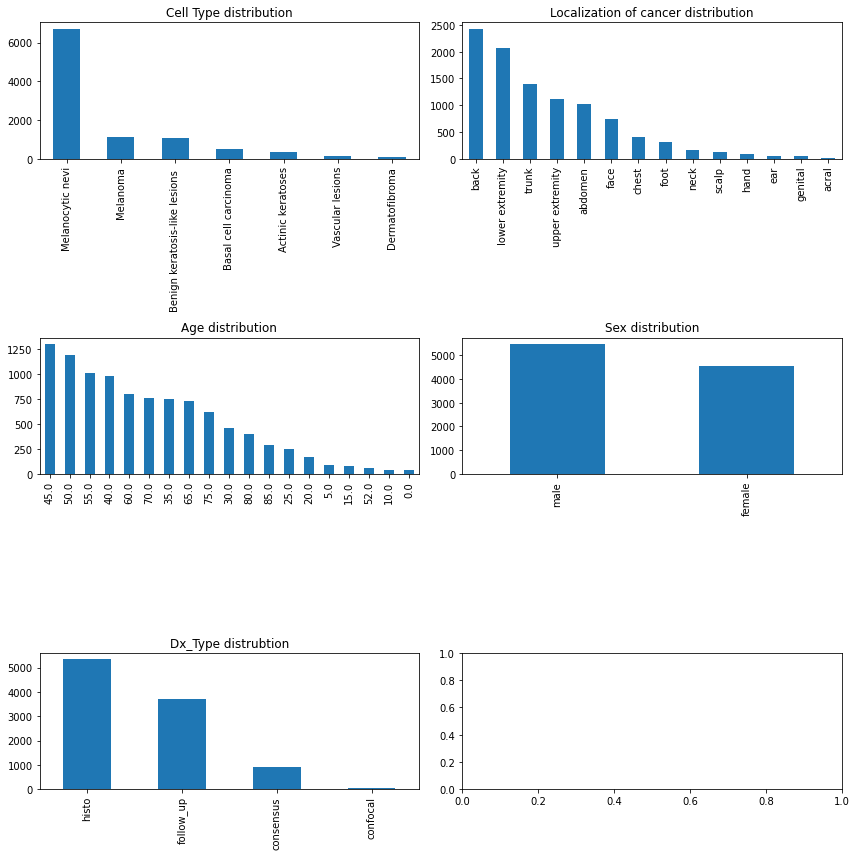

In [ ]:
fig, ax1 = plt.subplots(3,2,figsize=(12,12))
metadata['cell_type'].value_counts().plot(ax=ax1[0,0],kind='bar')
ax1[0,0].set_title('Cell Type distribution')
metadata['localization'].value_counts().plot(ax=ax1[0,1],kind='bar')
ax1[0,1].set_title('Localization of cancer distribution')
metadata['age'].value_counts().plot(ax=ax1[1,0],kind='bar')
ax1[1,0].set_title('Age distribution')
metadata['sex'].value_counts().plot(ax=ax1[1,1],kind='bar')
ax1[1,1].set_title('Sex distribution')
metadata['dx_type'].value_counts().plot(ax=ax1[2,0],kind='bar')
ax1[2,0].set_title('Dx_Type distrubtion')
plt.tight_layout()    #to prevent axis data from getting cut

<Figure size 432x288 with 0 Axes>

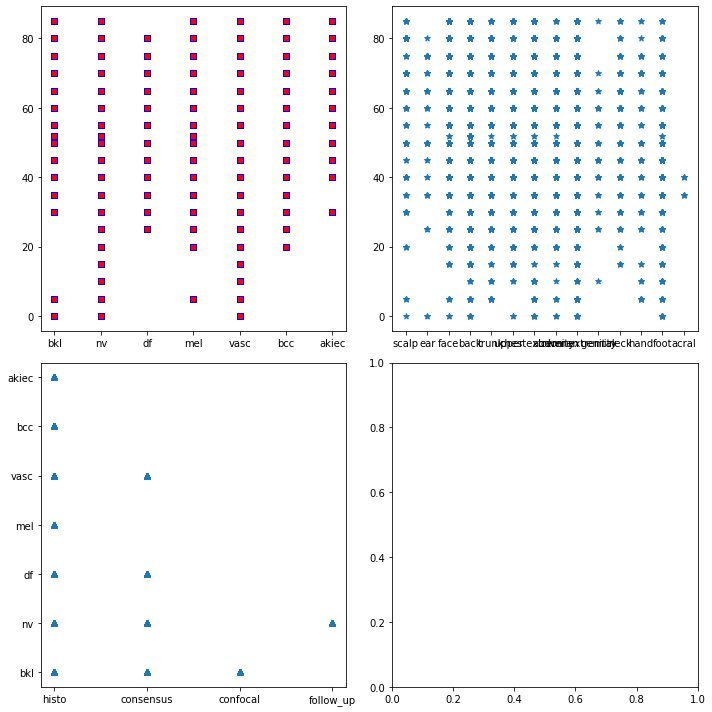

In [ ]:
f = plt.figure()
f, axes = plt.subplots(2,2,figsize=(10,10))
axes[0][0].scatter(metadata['dx'],metadata['age'],c='red',marker='s',edgecolor='blue')
axes[0][1].scatter(metadata['localization'],metadata['age'],marker='*')
axes[1][0].scatter(metadata['dx_type'],metadata['dx'],marker='^')
plt.tight_layout()


# Testing the image data

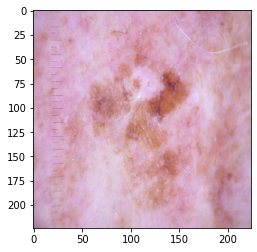

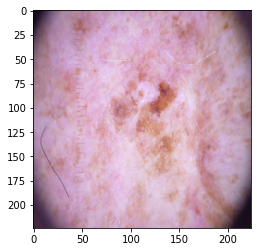

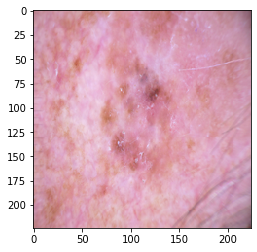

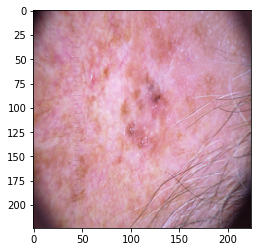

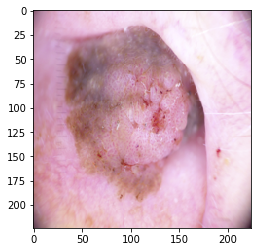

In [ ]:
#testing the image data
metadata['image'].map(lambda x: x.shape).value_counts()
img1 = metadata.iloc[:5]['image']

for img in img1:
  plt.imshow(img, interpolation='nearest')
  plt.show()

# Model parameters set up

In [ ]:
x_train    = np.load('/content/gdrive/My Drive/kaggle/x_train_224.npy')
x_validate = np.load('/content/gdrive/My Drive/kaggle/x_validate_224.npy')
y_train    = np.load('/content/gdrive/My Drive/kaggle/y_train_224.npy')
y_validate = np.load('/content/gdrive/My Drive/kaggle/y_validate_224.npy')
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [ ]:
features = metadata.drop(columns=['cell_type_idx'],axis=1)
target   = metadata['cell_type_idx'] 

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.2, random_state=2)

x_train = np.asarray(x_train_o['image'].tolist())
x_test  = np.asarray(x_test_o['image'].tolist())

x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train_o, test_size = 0.1, random_state = 2)

#y_train = to_categorical(y_train_o, num_classes = 7)
#y_test = to_categorical(y_test_o, num_classes = 7)

In [ ]:
training_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    horizontal_flip = True,
    vertical_flip = True
)

validation_datagen = ImageDataGenerator(rescale = 1.0/255)

In [ ]:
np.save('/content/gdrive/My Drive/kaggle/x_train_224.npy', x_train)
np.save('/content/gdrive/My Drive/kaggle/x_validate_224.npy', x_validate)
np.save('/content/gdrive/My Drive/kaggle/y_train_224.npy', y_train)
np.save('/content/gdrive/My Drive/kaggle/y_validate_224.npy', y_validate)

In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def IoU(y_true,y_pred):
  m = tf.keras.metrics.MeanIoU(num_classes=7)
  m.update_state(y_test, y_pred)
  m = m.result().numpy()
  return m

# CNN

In [ ]:
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/kaggle/CNN.h5')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-79-32ff6300b394>", line 2, in <module>
    model = load_model('/content/gdrive/My Drive/kaggle/CNN.h5')
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/saving/save.py", line 186, in load_model
    loader_impl.parse_saved_model(filepath)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/saved_model/loader_impl.py", line 113, in parse_saved_model
    constants.SAVED_MODEL_FILENAME_PB))
OSError: SavedModel file does not exist at: /content/gdrive/My Drive/kaggle/CNN.h5/{saved_model.pbtxt|saved_model.pb}

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_t

OSError: ignored

In [ ]:
y_train = to_categorical(y_train, 7)
y_validate = to_categorical(y_validate, 7)
y_test = to_categorical(y_test,7)

In [ ]:
print(y_test.shape)

(721, 7)


In [ ]:
#neural network
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(224,224,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(7,activation='softmax')
        
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [ ]:
#compiler
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',f1_m,precision_m,recall_m])

In [ ]:
history = model.fit(x_train, y_train, batch_size=30,epochs = 50,validation_data = (x_validate, y_validate))


Epoch 1/50
217/217 [==============================] - 12s 53ms/step - loss: 11.3544 - accuracy: 0.6425 - f1_m: 0.5659 - precision_m: 0.7912 - recall_m: 0.4598 - val_loss: 1.0341 - val_accuracy: 0.6833 - val_f1_m: 0.6796 - val_precision_m: 0.7971 - val_recall_m: 0.5958
Epoch 2/50
217/217 [==============================] - 11s 51ms/step - loss: 0.9517 - accuracy: 0.6724 - f1_m: 0.6342 - precision_m: 0.8306 - recall_m: 0.5224 - val_loss: 0.9339 - val_accuracy: 0.6671 - val_f1_m: 0.6192 - val_precision_m: 0.8564 - val_recall_m: 0.4924
Epoch 3/50
217/217 [==============================] - 11s 51ms/step - loss: 0.8510 - accuracy: 0.6958 - f1_m: 0.6759 - precision_m: 0.8440 - recall_m: 0.5697 - val_loss: 0.8860 - val_accuracy: 0.6933 - val_f1_m: 0.6779 - val_precision_m: 0.8142 - val_recall_m: 0.5855
Epoch 4/50
217/217 [==============================] - 11s 51ms/step - loss: 0.7586 - accuracy: 0.7232 - f1_m: 0.7078 - precision_m: 0.8475 - recall_m: 0.6119 - val_loss: 0.9247 - val_accuracy: 0.

In [ ]:
model.save('content\gdrive\My Drive\kaggle\CNN.h5')

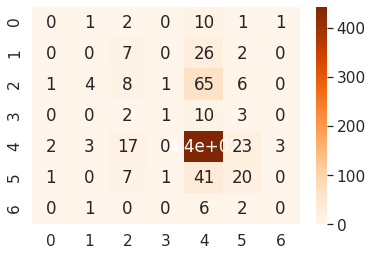

(721, 7)
IoU 0.4483483

Training accuracy: 0.7510525488853455 	 Validation: 0.662094761133194 	 testing: 0.6546463370323181
Training f1-Score: 0.7451214957237243 	 validation: 0.6532882523536682 	 testing 0.6413841843605042
Training Precision: 0.7873393273353577 	 validation: 0.6903953075408935 	 testing 0.6922190189361572
Training Recall: 0.7139834815263748 	 validation: 0.6253199112415314 	 testing: 0.5997442603111267


In [ ]:
import seaborn as sn
model.evaluate(x_test, y_test, verbose=0)
pred = model.predict(x_test)

cm = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(pred,axis=1))
df_cm = pd.DataFrame(cm, range(7), range(7))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, cmap='Oranges',annot=True) # font size

plt.show()

#print(pred1.shape)
print(y_test.shape)
avg_acc = np.mean(history.history['accuracy'])

m = tf.keras.metrics.MeanIoU(num_classes=7)
m.update_state(y_test, pred)
print('IoU',m.result().numpy())
test_loss, test_acc,f1_score,precision,recall = model.evaluate(x_test,  y_test, verbose=0)
print('\nTraining accuracy:', avg_acc, '\t Validation:',np.mean(history.history['val_accuracy']),'\t testing:',test_acc)
print('Training f1-Score:', np.mean(history.history['f1_m']),'\t validation:',np.mean(history.history['val_f1_m']),'\t testing',f1_score)
print('Training Precision:', np.mean(history.history['precision_m']),'\t validation:', np.mean(history.history['val_precision_m']),'\t testing',precision)
print('Training Recall:', np.mean(history.history['recall_m']), '\t validation:', np.mean(history.history['val_recall_m']),'\t testing:',recall)


dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


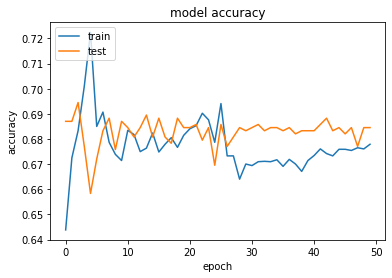

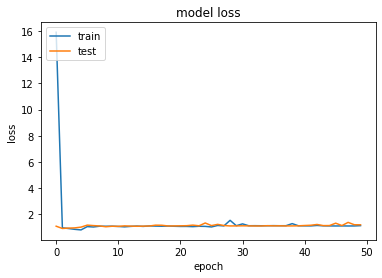

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


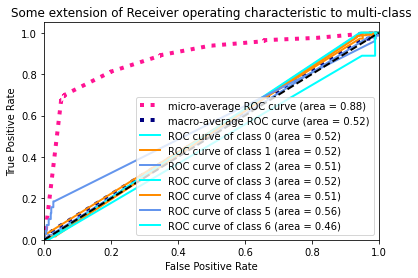

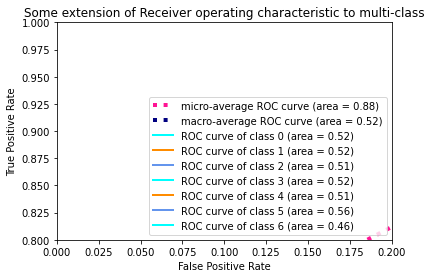

In [ ]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

y = y_test
y_score = pred
n_classes = 7

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

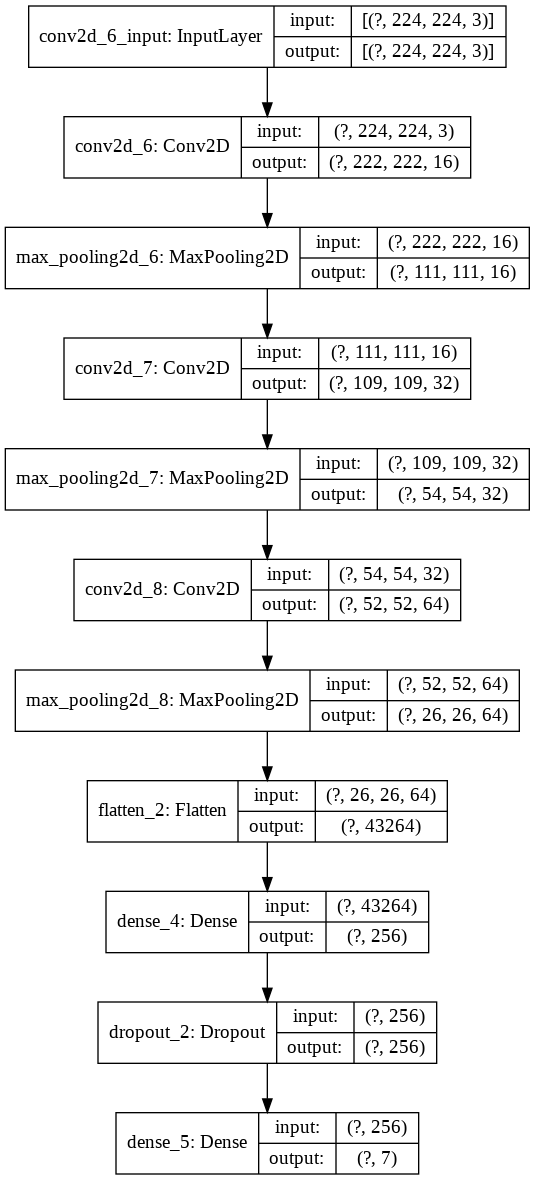

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)


# Efficientnets Model

In [ ]:
load_model('content\gdrive\My Drive\kaggle\effnets.h5')

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
IMG_SIZE=224

#with strategy.scope():
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
outputs = EfficientNetB0(include_top=True, weights=None, classes=7)(inputs)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy",f1_m,precision_m,recall_m,tf.keras.metrics.MeanIoU(num_classes=7)])

model.summary()

epochs = 40 

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7)                 4058538   
Total params: 4,058,538
Trainable params: 4,016,515
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
y_train = to_categorical(y_train, 7)
y_validate = to_categorical(y_validate, 7)
y_test = to_categorical(y_test,7)

In [ ]:
history = model.fit(x_train, y_train, batch_size=30,epochs = 50,validation_data = (x_validate, y_validate))


Epoch 1/50
217/217 [==============================] - 112s 514ms/step - loss: 1.6903 - accuracy: 0.6138 - f1_m: 0.5785 - precision_m: 0.6850 - recall_m: 0.5120 - mean_io_u_4: 0.4326 - val_loss: 1.1745 - val_accuracy: 0.6858 - val_f1_m: 0.6848 - val_precision_m: 0.6848 - val_recall_m: 0.6848 - val_mean_io_u_4: 0.4286
Epoch 2/50
217/217 [==============================] - 110s 506ms/step - loss: 1.1875 - accuracy: 0.6631 - f1_m: 0.6474 - precision_m: 0.7727 - recall_m: 0.5602 - mean_io_u_4: 0.4296 - val_loss: 1.0634 - val_accuracy: 0.6845 - val_f1_m: 0.6872 - val_precision_m: 0.6922 - val_recall_m: 0.6824 - val_mean_io_u_4: 0.4286
Epoch 3/50
217/217 [==============================] - 110s 506ms/step - loss: 1.0226 - accuracy: 0.6761 - f1_m: 0.6717 - precision_m: 0.7812 - recall_m: 0.5913 - mean_io_u_4: 0.4286 - val_loss: 0.8819 - val_accuracy: 0.6908 - val_f1_m: 0.6969 - val_precision_m: 0.7967 - val_recall_m: 0.6214 - val_mean_io_u_4: 0.4286
Epoch 4/50
217/217 [==========================

In [ ]:
model.save('content\gdrive\My Drive\kaggle\effnets.h5')
print('Model Saved')

Model Saved


(721, 7) (721, 7)


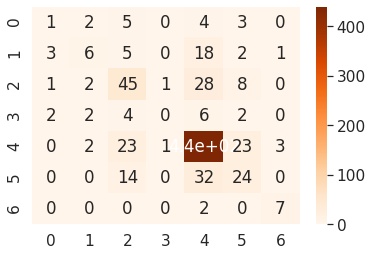

[[  1   2   5   0   4   3   0]
 [  3   6   5   0  18   2   1]
 [  1   2  45   1  28   8   0]
 [  2   2   4   0   6   2   0]
 [  0   2  23   1 439  23   3]
 [  0   0  14   0  32  24   0]
 [  0   0   0   0   2   0   7]]

Training accuracy: 0.88050547093153 	 Validation: 0.6966645956039429 	 testing: 0.7239944338798523
Training f1-Score: 0.8784098654985428 	 validation: 0.6869567163288594 	 testing 0.7237048745155334
Training Precision: 0.9123377114534378 	 validation: 0.7253029122948647 	 testing 0.7336623072624207
Training Recall: 0.8520744651556015 	 validation: 0.6628619834780693 	 testing: 0.7144341468811035
Training IoU: 0.4536443673074245 	 validation: 0.46416812017560005 	 testing: 0.4823620319366455


In [ ]:
import seaborn as sn
import pandas as pd
pred = model.predict(x_test)
print(y_test.shape,pred.shape)

cm = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(pred,axis=1))
df_cm = pd.DataFrame(cm, range(7), range(7))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, cmap='Oranges',annot=True) # font size

plt.show()
print(cm)

avg_acc = np.mean(history.history['accuracy'])
#m = tf.keras.metrics.MeanIoU(num_classes=7)
#m.update_state(y_test, pred)
#print(m.result().numpy())
test_loss, test_acc,f1_score,precision,recall,iou = model.evaluate(x_test,  y_test, verbose=0)
print('\nTraining accuracy:', avg_acc, '\t Validation:',np.mean(history.history['val_accuracy']),'\t testing:',test_acc)
print('Training f1-Score:', np.mean(history.history['f1_m']),'\t validation:',np.mean(history.history['val_f1_m']),'\t testing',f1_score)
print('Training Precision:', np.mean(history.history['precision_m']),'\t validation:', np.mean(history.history['val_precision_m']),'\t testing',precision)
print('Training Recall:', np.mean(history.history['recall_m']), '\t validation:', np.mean(history.history['val_recall_m']),'\t testing:',recall)
print('Training IoU:', np.mean(history.history['mean_io_u']), '\t validation:', np.mean(history.history['val_mean_io_u']),'\t testing:',iou)

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


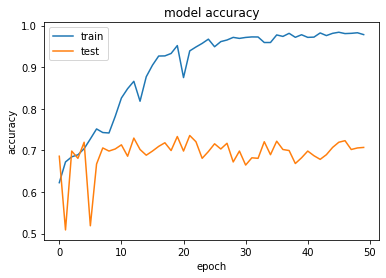

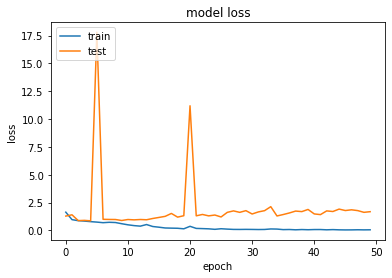

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


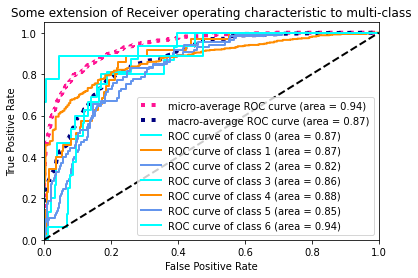

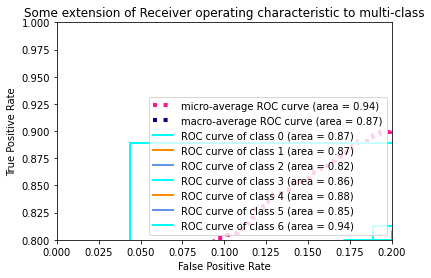

In [ ]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

y = y_test
y_score = pred
n_classes = 7

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

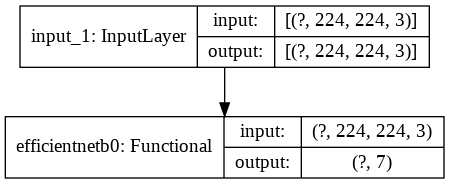

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)


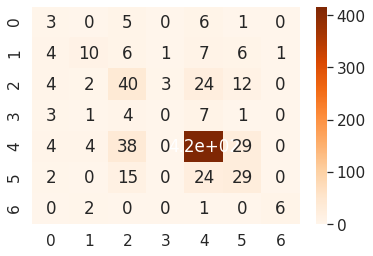

In [ ]:
cm = [[  2, 1, 1, 0, 8, 3, 0],
 [  3, 6, 4, 0, 19, 3, 0],
 [  9,   5,  15,   1,  49,   6,   0],
 [  2,   0,   4,   2,   5,   2,   1],
 [  4,   3,  14,   2, 459,   8,   1],
 [  3,   1,   5,   0,  44,  17,   0],
 [  0,   2,   0,   0,   2,   0,   5]]

cm = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(pred,axis=1))
df_cm = pd.DataFrame(cm, range(7), range(7))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, cmap='Oranges',annot=True) # font size

plt.show()